In [1]:
%reset -f -s

In [2]:
'''------------------------------------------------------------------
eRange Prediction with LSTM
---------------------------------------------------------------------
Version: V1.7       Modified: 06.11.2024        William Siegle
---------------------------------------------------------------------
(python -m) jupytext --to py FILENAME.ipynb
------------------------------------------------------------------'''
#import pathlib
from pathlib import Path, WindowsPath, PosixPath

# SETTINGS ------------------------------------------------------------------------
CONFIG = {
    # SYSTEM: ---------------------------------------------------------------------
    "GPU_SELECT":       2, # {0,1,2,3, None: CPU only}
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_final"), 
    "OUTPUT_LOCATION":  Path("src", "models", "pth"),
    "SEED"  :           55,
    "PLOT_ACTIVE":      False,

    # DATA PREPROCESSING: ---------------------------------------------------------
    "TRAIN_VAL_TEST":   [0.8, 0.15, 0.05], # [train, val, test splits]
    "MAX_FILES":        1000, # None: all files
    "SCALERS":          {'feature_scaler': 'MaxAbsScaler()', 'target_scaler': 'MinMaxScaler(feature_range=(0, 1))'},
    "MIN_SEQ_LENGTH":   600, # minimum sequence length in s to be included in DataSets

    # FEATURES: -------------------------------------------------------------------
    "FEATURES":         ['actdrvtrnpwrprc_cval','altitude_cval_ippc','motortemperature_pti1',
                        'brktempra_cval','hv_batmaxdischrgpwrlim_cval_1',
                        'emot_pwr_cval','actualtorque_pti1','powerstagetemperature_pti1',
                        'accelpdlposn_cval','airtempoutsd_cval_cpc','airtempinsd_cval_hvac','actualdcvoltage_pti1','hv_batavcelltemp_cval_bms1',
                        'epto_pwr_cval','maxtracpwrpct_cval','airtempinsd_rq','bs_brk_cval','brc_stat_brc1','vehspd_cval_cpc',
                        'vehweight_cval_pt','actualspeed_pti1','selgr_rq_pt',
                        'rmsmotorcurrent_pti1','roadgrad_cval_pt','currpwr_contendrnbrkresist_cval','elcomp_pwrcons_cval',
                        'hv_ptc_cabin1_pwr_cval','maxrecuppwrprc_cval','txoiltemp_cval_tcm'],
    "TARGETS":          ['hv_bat_soc_cval_bms1'],

    # MODEL: -----------------------------------------------------------------------
    "HIDDEN_SIZE":      400,    # features in the hidden state h
    "NUM_LAYERS":       2,      # recurrent layers for stacked LSTMs. Default: 1
    "DROPOUT":          0.5,
    
    # TRAINING & OPTIMIZER: --------------------------------------------------------
    "NUM_EPOCHS":       2,
    "BATCH_SIZE":       32,   # [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
    "LEARNING_RATE":    1e-2,   # 0.001 lr
    "OPTIMIZER":        "torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = 1e-3)",      
                        # weight_decay = 1e-4     # weight decay coefficient (default: 1e-2)
                        # betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
                        # eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
    "LRSCHEDULER":      "torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 2, factor = 0.5, min_lr = 1e-7)",

    # LOSS FUNCTION: ---------------------------------------------------------------
    "CRITERION":        "nn.SmoothL1Loss()", # ['nn.MSELoss()', 'nn.L1Loss()', 'nn.SmoothL1Loss()', 'nn.HuberLoss()', 'MASE()']
    "LOSS_FN":          "F.mse_loss(output, target)", # ['F.mse_loss(output, target)', 'F.l1_loss(output, target)', 'F.smooth_l1_loss(output, target)', 'F.huber_loss(output, target)', 'F.mase_loss(output, target)']

    # SAVE & LOAD: -----------------------------------------------------------------
    "MODE":             "train_mode", # ['train_mode', 'test_mode']
    "TRAIN_LOG":        "test1.txt",
}

___
LOCATE DEVICES & SYSTEM FOLDERS

In [3]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
# ----------------------------------------------------------------------------------------
import sys, os
for key in CONFIG: globals()[key] = CONFIG[key]
if 'ROOT' not in globals(): ROOT = Path('../..').resolve()
sys.path.append(os.path.abspath(ROOT))

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
from src.__init__ import *
from src.utils.data_utils import *
from src.utils.preprocess_utils import *
from src.utils.eval_utils import *
from src.utils.Trainer import *
from src.LSTM.lstm_models import *

# SETUP ENVIRONMENT ---------------------------------------------------------------------
DATA_PATH, IS_NOTEBOOK, DEVICE = setup_environment(CONFIG, ROOT, SEED, GPU_SELECT)

------------------------------------------------------------
Directories:
  /home/sieglew/MA-eR-PINN:			project, ref, test, data, src, .git, archive
  /home/sieglew/MA-Data:			__pycache__, trips_processed_resampled, final, y_true, processed, TripSequences, trips_processed_pickles, final_2, trips_processed_final
------------------------------------------------------------
Running in notebook mode
CONFIG Dictionary:
---------------------------------------------------------------------------------------------------------------------------------
     Parameter        Value
--  ---------------  ------------------------------------------------------------------------------------------------------------
0   GPU_SELECT       2
1   ROOT             /home/sieglew/MA-eR-PINN
2   INPUT_LOCATION   TripSequences/trips_processed_final
3   OUTPUT_LOCATION  src/models/pth
4   SEED             55
5   PLOT_ACTIVE      False
6   TRAIN_VAL_TEST   [0.8, 0.15, 0.05]
7   MAX_FILES        1000
8   SCALERS     

___
DATA PREPROCESSING

In [4]:
# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pth_folder = Path(ROOT, OUTPUT_LOCATION)

files, trip_lengths, indices_by_length, sorted_trip_lengths, all_signals \
    = prepare_data(input_folder, pth_folder, MAX_FILES, MIN_SEQ_LENGTH, ROOT)

------------------------------------------------------------
Total Files:	1000
Filtered Files:	736
------------------------------------------------------------
              FileName  Length  Index
0     V18_T513.parquet   16806     65
1    V18_T1423.parquet   15586    465
2     V18_T889.parquet   15573    502
3     V13_T373.parquet   15476    674
4     V19_T369.parquet   14691    588
..                 ...     ...    ...
731    V4_T155.parquet     620     75
732  V18_T1093.parquet     616    122
733   V14_T552.parquet     612    421
734     V1_T11.parquet     608    252
735  V18_T1187.parquet     605    346

[736 rows x 3 columns]


In [5]:
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
# these signals are required for the physical Model calculation:
base_signals = ["signal_time", "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 
                "hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]

# these signals have to be dropped in order for appropriate training:
columns_to_drop = ["hv_batmomavldischrgen_cval_1", "latitude_cval_ippc", "longitude_cval_ippc", "signal_time", "hirestotalvehdist_cval_icuc"]

# ---------------------------------------------------
selection_1 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", "bs_brk_cval", "elcomp_pwrcons_cval",
               "epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 'brktempra_cval', 'selgr_rq_pt']
selection_2 = ["hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "hv_batpwr_cval_bms1", "emot_pwr_cval", "roadgrad_cval_pt"]
selection_3 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "vehweight_cval_pt"]

In [6]:
# FEATURE SELECTION  ----------------------------------------------------------------------------
TARGET_COLUMN = TARGETS
INPUT_COLUMNS = FEATURES
INPUT_COLUMNS = list(set(all_signals) - set(columns_to_drop) - set(TARGET_COLUMN))
print(f"{'-'*60}\nInput Signals:\t{len(INPUT_COLUMNS)}\nTarget Signals:\t{len(TARGET_COLUMN)}")

# FEATURE NORMALIZATION/SCALING -----------------------------------------------------------------
scaler = eval(SCALERS['feature_scaler'])
target_scaler = eval(SCALERS['target_scaler'])

------------------------------------------------------------
Input Signals:	38
Target Signals:	1


In [7]:
# INSTANTIATE MODEL --------------------
model = LSTM1(len(INPUT_COLUMNS), HIDDEN_SIZE, NUM_LAYERS, DROPOUT, DEVICE).to(DEVICE)
print_info(model)

------------------------------------------------------------
 LSTM1(
  (relu): ReLU()
  (fc_test): Linear(in_features=400, out_features=1, bias=True)
  (lstm): LSTM(38, 400, num_layers=2, batch_first=True, dropout=0.5)
) ------------------------------------------------------------
Model state_dict:
fc_test.weight:	 torch.Size([1, 400])
fc_test.bias:	 torch.Size([1])
lstm.weight_ih_l0:	 torch.Size([1600, 38])
lstm.weight_hh_l0:	 torch.Size([1600, 400])
lstm.bias_ih_l0:	 torch.Size([1600])
lstm.bias_hh_l0:	 torch.Size([1600])
lstm.weight_ih_l1:	 torch.Size([1600, 400])
lstm.weight_hh_l1:	 torch.Size([1600, 400])
lstm.bias_ih_l1:	 torch.Size([1600])
lstm.bias_hh_l1:	 torch.Size([1600])


In [8]:
# GENERATE DATALOADERS ---------------------------------------------------------------

# DATA SET SPLITTING AND SORTING ----------------------------------------------------------------
train_subset, val_subset, test_subset = random_split(files, TRAIN_VAL_TEST)

# DATALOADER SETTINGS ------------------------------------------------------------------
dataloader_settings = {
    'batch_size': 1,                # see *Note above
    'shuffle': True,                # shuffle the batches before each epoch
    'collate_fn': collate_fn,       # include optional arguments
    'num_workers': 4,               # number of workers
    'pin_memory': False if DEVICE.type == 'cpu' else True}

# PREPARE TRAIN, VAL & TEST DATALOADERS  ------------------------------------------------------------
train_subset, train_dataset, train_dataset_batches, train_loader = prepare_dataloader(train_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, scaler, target_scaler, dataloader_settings, fit=True, drop_last=True)

val_subset, val_dataset, val_dataset_batches, val_loader = prepare_dataloader(val_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, scaler, target_scaler, dataloader_settings)

test_subset, test_dataset, test_dataset_batches, test_loader = prepare_dataloader(test_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, scaler, target_scaler, dataloader_settings)

# print dataset info
subset_files = print_dataset_sizes(train_dataset, val_dataset, test_dataset, train_subset, val_subset, test_subset, files)

 --> Warning: Removed the last 13 samples to ensure a balanced batch size
fitting Scalers: MaxAbsScaler, MinMaxScaler
	50% of the fitting done...
Done. Create DataSets and DataLoaders...
	Number of batches created: 18
	Number of batches created: 4
	Number of batches created: 2
------------------------------------------------------------
Train size:  1926668		(Files: 576)
Val. size:   385283		(Files: 111)
Test size:   129826		(Files: 36) 
 ------------------------------------------------------------
	Removed 13 file from the dataset
------------------------------------------------------------
first 3 train files: ['V18_T1423.parquet', 'V18_T889.parquet', 'V13_T373.parquet']


In [9]:
if IS_NOTEBOOK and PLOT_ACTIVE: 
    visualize_padding(BATCH_SIZE, trip_lengths, sorted_trip_lengths, train_loader, val_loader, test_loader)
    check_batch(train_loader)

In [10]:
# TRAINING CONFIGURATION -----------------------------------------------------------------------

# OPTIMIZER --------------------------------------------------------------------------------
# common optimizers: ['torch.optim.Adam', 'torch.optim.SGD', 'torch.optim.RMSprop']
if 'OPTIMIZER' in globals(): optimizer = eval(OPTIMIZER)
else: optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE,
        weight_decay = 1e-4      # weight decay coefficient (default: 1e-2)
        #betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
        #eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
)
print(f"{'-'*60}\n{optimizer}\n{'-'*60}")

# LR SCHEDULER ----------------------------------------------------------------------------
if 'LRSCHEDULER' in globals(): scheduler = eval(LRSCHEDULER)
else: scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 2, factor = 0.5, min_lr = 1e-6)
print(f"LRScheduler: {scheduler.__class__}\n{'-'*60}")

# LOSS FUNCTION ----------------------------------------------------------------
def loss_fn(output, target):
    if 'LOSS_FN' in globals(): loss = eval(LOSS_FN)
    else: loss = F.mse_loss(output, target) # mean-squared error for regression
    return loss

# or define criterion function:
criterion_list = [nn.MSELoss(), nn.L1Loss(), nn.SmoothL1Loss(), nn.HuberLoss(), MASE()]

if 'CRITERION' in globals(): criterion = eval(CRITERION)
else: criterion = nn.SmoothL1Loss()
print(f"Loss_Fn: {LOSS_FN}\n{'-'*60}")
print(f"Criterion: {criterion.__class__}\n{'-'*60}\n")

------------------------------------------------------------
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.001
)
------------------------------------------------------------
LRScheduler: <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>
------------------------------------------------------------
Loss_Fn: F.mse_loss(output, target)
------------------------------------------------------------
Criterion: <class 'torch.nn.modules.loss.SmoothL1Loss'>
------------------------------------------------------------



In [11]:
# SET NETWORK TRAINER -----------------------------------------------------------------
TRAINER = PTrainer_Standard(
    model = model, 
    optimizer = optimizer,
    scheduler = scheduler, 
    loss_fn = criterion, 
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    num_epochs = NUM_EPOCHS, 
    device = DEVICE, 
    is_notebook = IS_NOTEBOOK,
    use_mixed_precision = False,
    log_file = TRAIN_LOG)

In [12]:
# START TRAINING -----------------------------------------------------------------
if MODE == 'train_mode': CHECKPOINT = TRAINER.train_model()

------------------------------------------------------------
Training Started.	Process ID: 1429332 
------------------------------------------------------------
Model: LSTM1	Parameters on device: CUDA:2
------------------------------------------------------------
Train/Batch size:	18 / 1
Loss:			SmoothL1Loss()
Optimizer:		AdamW
LR:			0.01
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/18 [00:00<?, ?batch/s]

  0%|          | 0/18 [00:00<?, ?batch/s]

------------------------------------------------------------
Training Completed.	Execution Time: 00:00:12
------------------------------------------------------------



In [13]:
# Example usage
CHECKPOINT, model_destination_path = save_checkpoint(TRAINER, train_loader, val_loader, test_loader, CHECKPOINT, CONFIG, subset_files, pth_folder)

Model saved to:	 /home/sieglew/MA-eR-PINN/src/models/pth/LSTM1_241208_220351.pth
------------------------------------------------------------
Size: 22.80 MB
------------------------------------------------------------


___

In [14]:
#%%skip
# LOAD MODEL -----------------------------------------------------------------
#model_destination_path = Path(pth_folder, "LSTM1_packed_241206_155418.pth")
model, optimizer, checkpoint = load_checkpoint(model_destination_path, model, optimizer, train_loader, DEVICE, GPU_SELECT)

Model loaded from:	/home/sieglew/MA-eR-PINN/src/models/pth/LSTM1_241208_220351.pth
------------------------------------------------------------
Model: LSTM1	Parameters on device: cuda:2
------------------------------------------------------------
Train/Batch size:	18 / 1
Loss:			SmoothL1Loss()
Optimizer:		AdamW
LR:			0.01
Weight Decay:		0.001
------------------------------------------------------------
 LSTM1(
  (relu): ReLU()
  (fc_test): Linear(in_features=400, out_features=1, bias=True)
  (lstm): LSTM(38, 400, num_layers=2, batch_first=True, dropout=0.5)
)


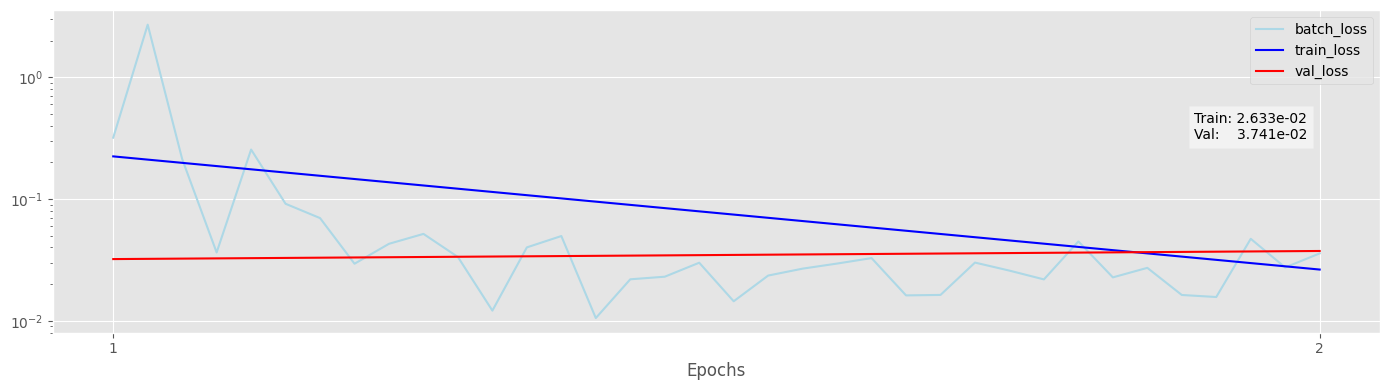

In [ ]:
# PLOT TRAINING PERFORMANCE -----------------------------------------------------------------
# get DataFrame of training metrics:
training_table = CHECKPOINT['training_table']
train_losses_per_iter = CHECKPOINT['train_losses_per_iter']
train_losses = CHECKPOINT['train_losses']
val_losses = CHECKPOINT['val_losses']
lr_history = CHECKPOINT['lr_history']
train_batches = CHECKPOINT['train_batches']

training_df = pd.DataFrame(training_table, columns=["Epoch", "Iteration", "Batch Loss", "Train Loss"])

# -------------------------------------
plot_training_performance(training_df, train_losses_per_iter, train_losses, val_losses, lr_history, train_batches)

In [18]:
# EVALUATION -----------------------------------------------------------------

# get file list of test subset
test_files = checkpoint["test_files"]
# -------------------------------------
# evaluate model on test set
test_loss, outputs, targets, original_lengths = TRAINER.evaluate_model()
# -------------------------------------
all_outputs, all_targets, all_original_lengths = [], [], []
for batch_outputs, batch_targets, batch_lengths in zip(outputs, targets, original_lengths):
    all_outputs.extend(batch_outputs)
    all_targets.extend(batch_targets)
    all_original_lengths.extend(batch_lengths)

# Inverse-transform on all outputs and targets for evaluation
scaled_outputs = [target_scaler.inverse_transform(output_sequence.reshape(1, -1)).squeeze() for output_sequence in all_outputs]
scaled_targets = [target_scaler.inverse_transform(target_sequence.reshape(1, -1)).squeeze() for target_sequence in all_targets]

print(f"Test Loss:  {test_loss:.6f}")
print(f"RMSE: {root_mean_squared_error(np.concatenate(scaled_targets), np.concatenate(scaled_outputs)):.4f}")
print(f"Standard Deviation: {np.std(np.concatenate(scaled_targets) - np.concatenate(scaled_outputs)):.4f}")

Test Loss:  0.022863
RMSE: 19.6048
Standard Deviation: 19.5413


In [19]:
# PLOT RESULTS -----------------------------------------------------------------
# get random sample sequence from test set
# -------------------------------------
sample_int = random.randint(1, len(scaled_outputs))
y_pred = scaled_outputs[sample_int]
y_true = scaled_targets[sample_int]

# -------------------------------------
plot_prediction(y_true, y_pred, PLOT_ACTIVE)